In [ ]:
import pickle
import numpy as np
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt

Function for plotting the temperature effect

In [3]:
def plot_temp_effect_from_file(path):
    with open(path, "rb") as f:
        results = pickle.load(f)
    observed = results["observed"]
    forecast = results["forecast"]
    hist = results["hist"]
    temps = observed["temps"]
    mean_temp = observed["global_mean_temp"]
    curves_observed = observed["curves"]
    curves_forecast = forecast["curves"]
    bins = hist["bins"]
    frac_observed = hist["frac_observed"]
    frac_forecast = hist["frac_forecast"]
    rain_levels = results["meta"]["rain_levels"]

    # ---- Plot ----
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    ax2.patch.set_alpha(0)
    width = bins[1] - bins[0]
    h_observed = ax2.bar(bins[:-1], frac_observed, width=width, color="#f4d0c0", alpha=0.5, align="edge", zorder=1)
    h_forecast = ax2.bar(bins[:-1], frac_forecast, width=width, color="#c0d4f4", alpha=0.5, align="edge", zorder=1)
    ax2.set_ylabel("Fraction of all data points")
    ax2.set_ylim(0, max(frac_observed.max(), frac_forecast.max()) * 1.1)
    observed_colors = ["#08519c", "#e67300", "#2a7f24"]
    forecast_colors = ["#4a90d9", "#fdae61", "#66c266"]
    for r, c_act, c_forecast in zip(rain_levels, observed_colors, forecast_colors):
        ax1.fill_between(
            temps,
            curves_observed[r]["low"],
            curves_observed[r]["high"],
            color=to_rgba(c_act, 0.40),
            zorder=2
        )
        ax1.plot(
            temps,
            curves_observed[r]["mean"],
            lw=2.5,
            color=c_act,
            label=f"Rain={r} mm (observed)",
            zorder=3,
        )
        ax1.fill_between(
            temps,
            curves_forecast[r]["low"],
            curves_forecast[r]["high"],
            color=to_rgba(c_forecast, 0.40),
            zorder=2.5,
        )
        ax1.plot(
            temps,
            curves_forecast[r]["mean"],
            lw=2.5,
            color=c_forecast,
            label=f"Rain={r} mm (forecast)",
            zorder=4,
        )
    ax1.axvline(
        mean_temp,
        color="red",
        lw=2, ls="--",
        label=f"Global mean temp ≈ {mean_temp:.1f}°C",
        zorder=4,
    )
    ax1.axhline(0, color="black", lw=1, zorder=4)
    ax1.set_xlabel("Temperature (°C)")
    ax1.set_ylabel("Bike count change relative to mean temp (%)")
    ax1.set_title("Temperature effect: observed vs forecast weather")
    handles1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(
        handles1 + [h_observed, h_forecast],
        labels1 + ["observed temp", "forecast temp"],
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

Plot temperature effect

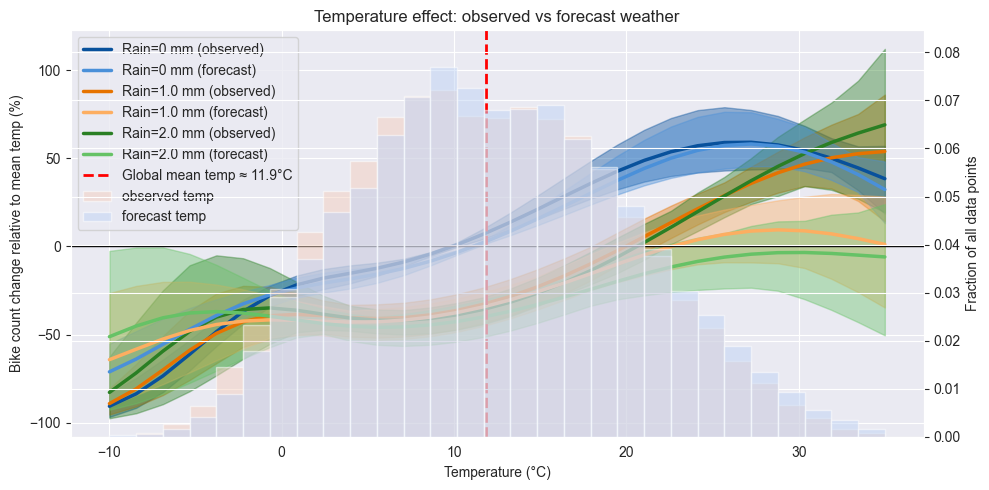

In [8]:
plot_temp_effect_from_file("../data/temp_effect_results.pkl")

Function for plotting the rain curve

In [9]:
def plot_rain_effect_from_file(path):
    # -------------------------------------------------
    # Load results
    # -------------------------------------------------
    with open(path, "rb") as f:
        results = pickle.load(f)
    rain_grid = results["observed"]["rain_grid"]
    summary_observed = results["observed"]["curves"]
    summary_forecast   = results["forecast"]["curves"]
    bins = results["hist"]["bins"]
    frac_observed = results["hist"]["frac_observed"]
    frac_forecast   = results["hist"]["frac_forecast"]
    temps_fixed = results["meta"]["temps_fixed"]
    # -------------------------------------------------
    # Plot setup
    # -------------------------------------------------
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    observed_colors = ["#08519c", "#e67300", "#2a7f24"]# blue, orange, green
    forecast_colors   = ["#4a90d9", "#fdae61", "#66c266"]  # lighter variants
    # -------------------------------------------------
    # Rain effect curves with CIs
    # -------------------------------------------------
    for T, c_observed, c_forecast in zip(temps_fixed, observed_colors, forecast_colors):
        # observed
        ax1.fill_between(
            rain_grid,
            summary_observed[T]["low"],
            summary_observed[T]["high"],
            color=to_rgba(c_observed, 0.40),
            zorder=2,
        )
        ax1.plot(
            rain_grid,
            summary_observed[T]["mean"],
            lw=2.5,
            color=c_observed,
            label=f"T={T}°C (observed)",
            zorder=3,
        )
        # forecast
        ax1.fill_between(
            rain_grid,
            summary_forecast[T]["low"],
            summary_forecast[T]["high"],
            color=to_rgba(c_forecast, 0.40),
            zorder=2.5,
        )
        ax1.plot(
            rain_grid,
            summary_forecast[T]["mean"],
            lw=2,
            color=c_forecast,
            label=f"T={T}°C (forecast)",
            zorder=4,
        )
    # -------------------------------------------------
    # Histogram (fractions)
    # -------------------------------------------------
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    width = bins[1] - bins[0]
    h_observed = ax2.bar(
            bin_centers,
            frac_observed,
            width=width,
            color="lightgray",
            alpha=0.3,
            align="center",
            label="observed rain",
            zorder=1,
    )
    h_forecast = ax2.bar(
            bin_centers,
            frac_forecast,
            width=width,
            color="lightblue",
            alpha=0.3,
            align="center",
            label="forecast rain",
            zorder=1,
    )
    ax2.set_ylabel("Fraction of all data points")
    ax2.set_ylim(0, max(frac_observed.max(), frac_forecast.max()) * 1.1)
    # -------------------------------------------------
    # Labels, legend, layout
    # -------------------------------------------------
    ax1.set_xlabel("Rain (mm)")
    ax1.set_ylabel("Bike count change relative to 0 mm rain (%)")
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
            handles1 + handles2,
            labels1 + labels2,
            loc="upper left",
    )
    ax1.set_title("Marginal effect of rain on bike counts\nobserved vs forecast Weather")
    plt.tight_layout()
    plt.show()

Plot rain effect

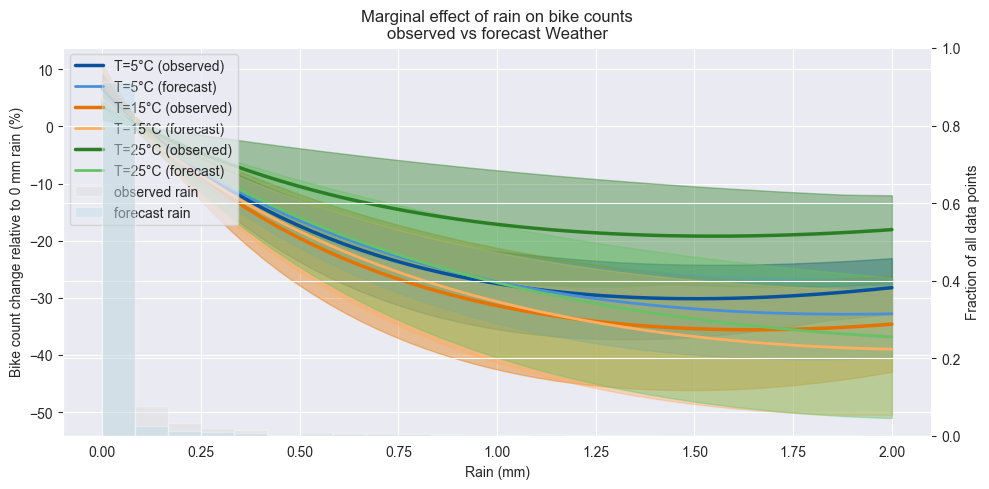

In [11]:
plot_rain_effect_from_file("../data/rain_effect_results.pkl")